In [21]:
import pandas as pd
import numpy as np
import json

In [3]:
business_data = json.load(open("yelp_dataset/yelp_filtered_philadelphia_business.json"))

# Create a DataFrame for business data
business_df = pd.DataFrame(business_data)

# Flatten the nested "attributes" column
business_attributes = pd.json_normalize(business_df['attributes'])
business_attributes.columns = [f'attributes.{col}' for col in business_attributes.columns]

business_hours = pd.json_normalize(business_df['hours'])
business_hours.columns = [f'WorkingHours.{col}' for col in business_hours.columns]


# Concatenate the flattened attributes DataFrame with the original business DataFrame
business_df = pd.concat([business_df, business_attributes], axis=1)
business_df = pd.concat([business_df, business_hours], axis=1)

# Drop the original nested "attributes" column
business_df = business_df.drop('attributes', axis=1)
business_df = business_df.drop('hours', axis=1)

In [6]:
review_data = json.load(open("yelp_dataset/yelp_filtered_philadelphia_reviews.json"))
review_df = pd.DataFrame(review_data)

### Each review is unique

In [8]:
review_df["review_id"].duplicated().sum()

0

In [10]:
business_df["is_open"].value_counts()

1    10542
0     4027
Name: is_open, dtype: int64

### Filter permanently closed businesses

In [11]:
business_df = business_df[business_df["is_open"] == 1]

In [12]:
business_df.drop(columns=["city", "state", "latitude", "longitude", "is_open"], inplace=True)
review_df.drop(columns=["review_id", "user_id", "date"], inplace=True)

### Filter reviews for businesses that are still open

In [13]:
review_df = review_df[review_df["business_id"].isin(business_df["business_id"])]

5    234953
4    150610
3     68269
1     52162
2     41800
Name: stars, dtype: int64


<Axes: >

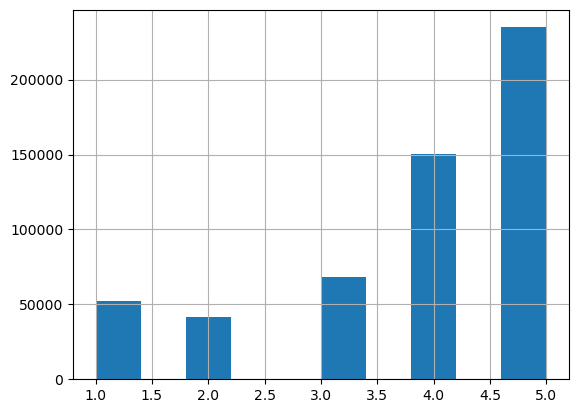

In [17]:
print(review_df["stars"].value_counts())
review_df["stars"].hist()

In [27]:
# Fill "closed" if not all columns are empty
def fill_closed(row):
    if row.isnull().all():
        return row
    else:
        return row.fillna("closed")

# Selecting only the columns related to working hours
working_hours_columns = [f'WorkingHours.{day}' for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

# Applying the custom function to the selected columns
business_df[working_hours_columns] = business_df[working_hours_columns].apply(fill_closed, axis=1)


In [28]:
print(f"Number of rows: {business_df.shape[0]}")
business_df.isna().sum()

Number of rows: 10542


business_id                                  0
name                                         0
address                                      0
postal_code                                  0
stars                                        0
review_count                                 0
categories                                   7
attributes.RestaurantsDelivery            6552
attributes.OutdoorSeating                 7345
attributes.BusinessAcceptsCreditCards     2128
attributes.BusinessParking                4323
attributes.BikeParking                    5298
attributes.RestaurantsPriceRange2         4913
attributes.RestaurantsTakeOut             6405
attributes.ByAppointmentOnly              7335
attributes.WiFi                           6580
attributes.Alcohol                        7680
attributes.Caters                         7774
attributes.RestaurantsReservations        7587
attributes.RestaurantsGoodForGroups       7727
attributes.RestaurantsAttire              8140
attributes.Ha